In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import numpy as np
import datetime

def accuracy(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        #print('\nset_true: {0}'.format(set_true), ', set_pred: {0}'.format(set_pred))
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

def precision(y_true, y_pred, normalize=True, sample_weight=None):
    pre_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_prec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_prec = 1
            pre_list.append(tmp_prec)
        elif len(set_pred) > 0:
            tmp_prec = len(set_true.intersection(set_pred))/\
                    float(len(set_pred))
            pre_list.append(tmp_prec)
        else:
            None
    return np.mean(pre_list)

def recall(y_true, y_pred, normalize=True, sample_weight=None):
    rec_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_rec = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_rec = 1
        else:
            tmp_rec = len(set_true.intersection(set_pred))/\
                    float(len(set_true))
        rec_list.append(tmp_rec)
    return np.mean(rec_list)

def f_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = (2*len(set_true.intersection(set_pred)))/\
                    float( len(set_true) + len(set_pred))
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
from csv import writer
import pandas as pd

def test_segment(filename, low, up):
    myFile = open(filename, 'w', newline = '')
    with myFile:
        csv_writer = writer(myFile)
        for j, row in enumerate(seqData):
            segment = [ ]
            if(len(row) > low and len(row) < up):
                segment.append(row)
                for item in label[j]:
                    segment.append(item)
                csv_writer.writerow(segment)
    myFile.close()

dataframe = pd.read_csv("/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/test_data_mf2.csv", header=None)
dataset = dataframe.values
seqData = dataset[:,0]
label = dataset[:,1:len(dataset[0])]
print('Original Dataset Size : %s' %len(dataset))
test_segment('testData200.csv', 0, 201)
test_segment('testData500.csv', 200, 501)
test_segment('testData1000.csv', 500, 1001)
test_segment('testData16000.csv', 1000, 16000)

Original Dataset Size : 1137


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import math

def segment(dataset, label, seg_size, overlap):
    print("Non-overlapping Region: %s" %overlap)
    print("Segment Size: %s" %seg_size)

    seq_data, label_data = [], []
    for j, row in enumerate(dataset):
        if(len(row) < 2001):
            pos = math.ceil(len(row)/overlap)
            if(pos < math.ceil(seg_size/overlap)):
                pos = math.ceil(seg_size/overlap)
            for itr in range(pos - math.ceil(seg_size/overlap) + 1):
                init = itr * overlap
                if(len(row[init : init + seg_size]) > 50):
                    seq_data.append(row[init : init + seg_size])
                    label_data.append(label[j])
    return seq_data, label_data

dataframe = pd.read_csv('/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/train_data_mf2.csv', header=None)
dataset = dataframe.values
print('Original Dataset Size : %s' %len(dataset))
X = dataset[:,0]
Y = dataset[:,1:len(dataset[0])]
del dataframe, dataset
print(X.shape, Y.shape)

# Preparing For Training
segmentSize = 150
nonOL = segmentSize - 50
SEG = str(segmentSize)

X, Y = segment(X, Y, segmentSize, nonOL)
nb_of_cls = len(Y[0])

#Split the dataset
x_tr, x_val, y_tr, y_val = train_test_split(X, Y, test_size = 0.1, random_state = 42)
del X, Y

y_train = np.array(y_tr, dtype=float)
y_validate = np.array(y_val, dtype=float)
print(len(x_tr), len(x_val))
print(y_train.shape, y_validate.shape)

del y_tr, y_val

Original Dataset Size : 36110
(36110,) (36110, 677)
Non-overlapping Region: 100
Segment Size: 150
146617 16291
(146617, 677) (16291, 677)


In [ ]:
import math
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
np.random.seed(7)

def dictionary(chunk_size):
    dataframe = pd.read_csv('/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/train_data_mf2.csv', header=None)
    dataset = dataframe.values
    del dataframe

    seq_dataset = dataset[:,0]
    print('Creating Dictionary:')
    dict = {}
    j = 0
    for row in seq_dataset:
        for i in range(len(row) - chunk_size + 1):
            key = row[i:i + chunk_size]
            if key not in dict:
                dict[key] = j
                j = j + 1
    del dataset, seq_dataset
    return(dict)

def nGram(dataset, chunk_size, dictI):
    dict1 = list()
    for j, row in enumerate(dataset):
        string = row
        dict2 = list()
        for i in range(len(string) - chunk_size + 1):
            try:
                dict2.append(dictI[string[i:i + chunk_size]])
            except:
                None
        dict1.append(dict2)
    return(dict1)

# CREATING DICTIONARY
chunkSize = 4
dict_Prop = dictionary(chunkSize)
max_seq_len = segmentSize - chunkSize + 1

Creating Dictionary:


In [ ]:
class Bi_CNN(layers.Layer):
	def __init__(self, no_of_filters, filter_size,dilation_rate):
		super(Bi_CNN,self).__init__()
		self.no_of_filters = no_of_filters
		self.filter_size = filter_size
		self.dilation_rate = dilation_rate
		self.forward_cnn = layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
												  strides=1, padding='causal',activation='linear',use_bias=True)
		self.backward_cnn = layers.Conv1D(filters = no_of_filters, kernel_size=filter_size, dilation_rate=dilation_rate,
												   strides=1, padding='causal',activation='linear',use_bias=True)
		self.concat = layers.Concatenate(axis=-1)
		self.add = layers.Add()

	def call(self, inputs, mode='Concat'):
		f_cnn = self.forward_cnn(inputs)                  # Forward Pass
		r_input = tf.reverse(inputs, [-2])
		b_cnn = self.backward_cnn(r_input)                # Backward Pass
		b_cnn = tf.reverse(b_cnn,[-2])

		if mode == 'Concat':
			output = self.concat([f_cnn, b_cnn])
		elif mode == 'Add':
			output = self.add([f_cnn, b_cnn])
		else:
			output = f_cnn, b_cnn
		return output

	def get_config(self):
		config = super(Bi_CNN,self).get_config().copy()
		config.update({'no_of_filters': self.no_of_filters, 'filter_size': self.filter_size, 'dilation_rate': self.dilation_rate,})
		return config

def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
	def f(input_):
		residual = input_
		layer_out = Bi_CNN(no_of_filters = nb_filter, filter_size = filter_length, dilation_rate=dilation)(input_)

		layer_out = layers.BatchNormalization(epsilon=1.1e-5)(layer_out)
		layer_out = layers.LeakyReLU(alpha = 0.2)(layer_out)
		return layer_out
	return f


def DC_CNN_Block(nb_filter, filter_length, dilation, l2_layer_reg):
	def f(input_):
		residual = input_
		layer_out = Bi_CNN(no_of_filters = nb_filter, filter_size = filter_length, dilation_rate=dilation)(input_)

		layer_out = layers.BatchNormalization(epsilon=1.1e-5)(layer_out)
		layer_out = layers.LeakyReLU(alpha = 0.2)(layer_out)
		return layer_out
	return f

embed_dim = 32
f_num = 64
ff_dim = 1280
f_size = [5,5,5,5,5]
def DC_CNN_Model(top_words, seq_len, o_dim):
	#embed_dim = 32
	#f_num = 256
	#f_size = [6,6,6,6,6]
	#ff_dim = 200

	_input = layers.Input(shape=(seq_len,))
	emd = layers.Embedding(top_words, embed_dim, input_length = seq_len)(_input)
	drop1 = layers.Dropout(0.3)(emd)

	l1 = DC_CNN_Block(f_num, f_size[0], 1, 0.001)(drop1)
	l2 = DC_CNN_Block(f_num, f_size[1], 3, 0.001)(drop1)
	l3 = DC_CNN_Block(f_num, f_size[2], 5, 0.001)(drop1)
	l4 = DC_CNN_Block(f_num, f_size[3], 7, 0.001)(drop1)
	l5 = DC_CNN_Block(f_num, f_size[4], 9, 0.001)(drop1)

	x = layers.Concatenate()([l1, l2, l3, l4, l5])
	x = layers.GlobalAveragePooling1D()(x)
	x = layers.Dropout(0.4)(x)
	_output = layers.Dense(o_dim, kernel_initializer='normal', activation='sigmoid', name='CLASSIFIER')(x)

	model = keras.Model(inputs=_input, outputs=_output)
	model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
				  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
				  metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
	return model

#CREATING N-GRAM
x_train = nGram(x_tr, chunkSize, dict_Prop)
x_validate = nGram(x_val, chunkSize, dict_Prop)

# truncate and pad input sequences
x_train = sequence.pad_sequences(x_train, maxlen=max_seq_len)
x_validate = sequence.pad_sequences(x_validate, maxlen=max_seq_len)

# Create & Compile the model
model = DC_CNN_Model(len(dict_Prop), max_seq_len, nb_of_cls)
early_stopping_monitor1 = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
history = model.fit(x_train, y_train,
          validation_data = (x_validate, y_validate),
          epochs = 500,
          batch_size = 150,
          callbacks=[early_stopping_monitor1],
          verbose=1)

Epoch 1/500
978/978 [==============================] - 118s 109ms/step - loss: 0.0712 - binary_accuracy: 0.9819 - val_loss: 0.0556 - val_binary_accuracy: 0.9853
Epoch 2/500
978/978 [==============================] - 51s 52ms/step - loss: 0.0503 - binary_accuracy: 0.9861 - val_loss: 0.0505 - val_binary_accuracy: 0.9860
Epoch 3/500
978/978 [==============================] - 41s 42ms/step - loss: 0.0422 - binary_accuracy: 0.9879 - val_loss: 0.0483 - val_binary_accuracy: 0.9863
Epoch 4/500
978/978 [==============================] - 38s 39ms/step - loss: 0.0371 - binary_accuracy: 0.9891 - val_loss: 0.0477 - val_binary_accuracy: 0.9863
Epoch 5/500
978/978 [==============================] - 37s 38ms/step - loss: 0.0336 - binary_accuracy: 0.9898 - val_loss: 0.0472 - val_binary_accuracy: 0.9864
Epoch 6/500
978/978 [==============================] - 37s 38ms/step - loss: 0.0310 - binary_accuracy: 0.9904 - val_loss: 0.0474 - val_binary_accuracy: 0.9863
Epoch 7/500
978/978 [=======================

In [ ]:
#pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
from keras.models import load_model

def cls_predict(pred, normalize=True, sample_weight=None):
    s_mean = np.mean(pred, axis=0)
    m = max(s_mean)
    s_mean = (s_mean/m)
    return(list(s_mean))

def final_model(filename):
    print('Extracting features based on GRU model...... ')
    dataframe2 = pd.read_csv(filename, header=None)
    dataset2 = dataframe2.values
    overlap = 50
    X_test = dataset2[:,0]
    Y_test = dataset2[:,1:len(dataset2[0])]
    c_p = []
    for tag, row in enumerate(X_test):
        pos = math.ceil(len(row) / overlap)
        if(pos < math.ceil(segmentSize/ overlap)):
            pos = math.ceil(segmentSize/ overlap)
        segment = [ ]
        for itr in range(pos - math.ceil(segmentSize/overlap) + 1):
            init = itr * overlap
            segment.append(row[init : init + segmentSize])
        seg_nGram = nGram(segment, chunkSize, dict_Prop)
        test_seg = sequence.pad_sequences(seg_nGram, maxlen=max_seq_len)
        preds = model.predict(test_seg)
        c_p.append(cls_predict(preds))
    c_p = np.array(c_p)
    return c_p, Y_test

def create_nn_model(dim):
    n_model = keras.Sequential(
        [layers.Dense(dim, input_dim = dim, kernel_initializer='normal', activation='relu'),
        layers.Dense(dim, kernel_initializer='normal', activation='sigmoid'),]
        )
    n_model.compile(loss = tf.keras.losses.BinaryCrossentropy(),
                    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005),
                    metrics = tf.keras.metrics.BinaryAccuracy(threshold=0.5))
    return n_model

# Creates a HDF5 file 'my_model.h5'

model_path = '/content/gdrive/MyDrive/CAFA_C/bp/D_CNN/ablation/'+str(embed_dim)+'_model_'+str(ff_dim)+'_'+str(nonOL)+'_'+str(6)+'_'+ SEG +'.h5'
model.save(model_path)
#del model
#model = load_model(model_path)

# Training
X_train_new, Y_train_new = final_model('/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/train_data_mf2.csv')

# Training model 2
model1 = create_nn_model(Y_train_new[0].shape[0])
print(model1.summary())
early_stopping_monitor = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1)
model1.fit(X_train_new, Y_train_new.astype(None),
           callbacks = [early_stopping_monitor],
           validation_split = 0.1,
           epochs = 1000,
           batch_size = 150,
           verbose = True)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 43ms/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 677)               459006    
                                                                 
 dense_1 (Dense)             (None, 677)               459006    
                                                                 
Total params: 918012 (3.50 MB)
Trainable params: 918012 (3.50 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/1000
217/217 [==============================] - 2s 6ms/step - loss: 0.1257 - binary_accuracy: 0.9770 - val_loss: 0.0372 - val_binary_accuracy: 0.9920
Epoch 2/1000
217/217 [==============================] - 1s 5ms/step - loss: 0.0312 - binary_accuracy: 0.9924 - val_loss: 0.0248 - val_binary_accuracy:

Extracting features based on GRU model...... 
1/1 [==============================] - 0s 19ms/step
(1137, 677) (1137, 677)
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.01
Recall: 74.48863183333238      Precision: 13.972602057738575      F1-score1: 23.53121168791671       F1-score2: 21.36803725122365
36/36 [==============================] - 0s 1ms/step
THRESHOLD IS =====>  0.02
Recall: 68.77189349884021      Precision: 18.90707615515441      F1-score1: 29.659915777933648       F1-score2: 26.79097512772036
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.03
Recall: 65.22242463781024      Precision: 22.32501917196614      F1-score1: 33.2640638519392       F1-score2: 30.005848651720985
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.04
Recall: 62.917060532053135      Precision: 25.21999799292649      F1-score1: 36.006832242750555       F1-score2: 32.40644355300757
36/36 [==============================] - 0

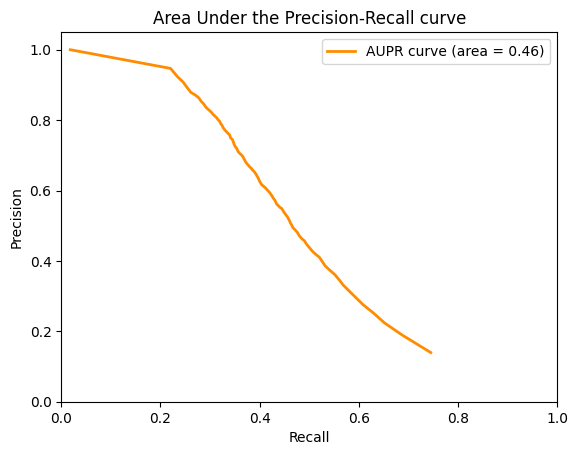

In [ ]:
from matplotlib import pyplot as plt

# Testing
def test_fun(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    Y_test_new = np.array(Y_test_new).astype(None)

    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = model1.predict(X_test_new)

        threshold = t / 100.0
        print("THRESHOLD IS =====> ", threshold)
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)

        rec = recall(Y_test_new, test_preds)
        pre = precision(Y_test_new, test_preds)
        recalls.append(rec)
        precisions.append(pre)

        f1 = f_score(Y_test_new, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax

th_set = test_fun("/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/test_data_mf2.csv")

In [ ]:
def test_fun(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    test_preds = model1.predict(X_test_new)
    Y_test_new = np.array(Y_test_new).astype(None)
    test_preds[test_preds>=th_set] = int(1)
    test_preds[test_preds<th_set] = int(0)
    rec = recall(Y_test_new, test_preds)*100
    pre = precision(Y_test_new, test_preds)*100
    f = 2 * pre * rec / (pre + rec)
    f1 = f_score(Y_test_new, test_preds)*100
    print('   Recall: {0}'.format(rec),  '    Precision: {0}'.format(pre),  '    F1-score: {0}'.format(f), '    F1-score: {0}'.format(f1))

print("Best Threshold: ", th_set)
test_fun('/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/test_data_mf2.csv')
test_fun("testData200.csv")
test_fun("testData500.csv")
test_fun("testData1000.csv")
test_fun("testData16000.csv")

print('/n')
print("code Completion date is :", datetime.datetime.now())

Best Threshold:  0.43
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 17ms/step
(1137, 677) (1137, 677)
36/36 [==============================] - 0s 2ms/step
   Recall: 42.05385984135109     Precision: 59.32657043749517     F1-score: 49.218794419874264     F1-score: 44.01473468247748
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 38ms/step
(289, 677) (289, 677)
10/10 [==============================] - 0s 3ms/step
   Recall: 38.02547087634138     Precision: 44.58487727869728     F1-score: 41.04475989629279     F1-score: 35.46547029308208
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 18ms/step
(499, 677) (499, 677)
16/16 [==============================] - 0s 2ms/step
   Recall: 43.303014460470564     Precision: 63.060941649003155     F1-score: 51.34688418898423     F1-score: 46.39441958548717
Extracting features based on GRU model...... 
1/1 [=========================

Extracting features based on GRU model...... 
1/1 [==============================] - 0s 23ms/step
(1137, 677) (1137, 677)
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.01
Recall: 74.48863183333238      Precision: 13.972602057738575      F1-score1: 23.53121168791671       F1-score2: 21.36803725122365
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.02
Recall: 68.77189349884021      Precision: 18.90707615515441      F1-score1: 29.659915777933648       F1-score2: 26.79097512772036
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.03
Recall: 65.22242463781024      Precision: 22.32501917196614      F1-score1: 33.2640638519392       F1-score2: 30.005848651720985
36/36 [==============================] - 0s 2ms/step
THRESHOLD IS =====>  0.04
Recall: 62.917060532053135      Precision: 25.21999799292649      F1-score1: 36.006832242750555       F1-score2: 32.40644355300757
36/36 [==============================] - 0

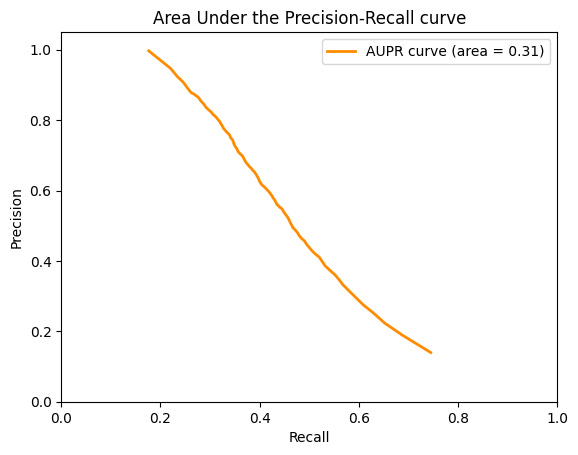

In [ ]:
from matplotlib import pyplot as plt

# Testing
def test_fun(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    Y_test_new = np.array(Y_test_new).astype(None)

    fmax, tmax = 0.0, 0.0
    precisions, recalls = [], []
    for t in range(1, 101, 1):
        test_preds = model1.predict(X_test_new)

        threshold = t / 100.0
        if threshold ==1:
          threshold = 0.9999
        print("THRESHOLD IS =====> ", threshold)
        test_preds[test_preds>=threshold] = int(1)
        test_preds[test_preds<threshold] = int(0)

        rec = recall(Y_test_new, test_preds)
        pre = precision(Y_test_new, test_preds)
        recalls.append(rec)
        precisions.append(pre)

        f1 = f_score(Y_test_new, test_preds)*100
        f = 2 * pre * rec / (pre + rec)
        if math.isnan(f):
          f = 0.0
        print('Recall: {0}'.format(rec*100), '     Precision: {0}'.format(pre*100),
              '     F1-score1: {0}'.format(f*100), '      F1-score2: {0}'.format(f1))

        if fmax < f:
            fmax = f
            tmax = threshold

    precisions = np.array(precisions)
    recalls = np.array(recalls)
    sorted_index = np.argsort(recalls)
    recalls = recalls[sorted_index]
    precisions = precisions[sorted_index]
    aupr = np.trapz(precisions, recalls)
    print(f'AUPR: {aupr:0.3f}')

    plt.figure()
    plt.plot(recalls, precisions, color='darkorange', lw=2, label=f'AUPR curve (area = {aupr:0.2f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Area Under the Precision-Recall curve')
    plt.legend(loc="upper right")
    plt.savefig(f'aupr.pdf')

    return tmax

th_set = test_fun("/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/test_data_mf2.csv")

In [ ]:
def test_fun(file):
    X_test_new, Y_test_new = final_model(file)
    print(X_test_new.shape, Y_test_new.shape)
    test_preds = model1.predict(X_test_new)
    Y_test_new = np.array(Y_test_new).astype(None)
    test_preds[test_preds>=th_set] = int(1)
    test_preds[test_preds<th_set] = int(0)
    rec = recall(Y_test_new, test_preds)*100
    pre = precision(Y_test_new, test_preds)*100
    f = 2 * pre * rec / (pre + rec)
    f1 = f_score(Y_test_new, test_preds)*100
    print('   Recall: {0}'.format(rec),  '    Precision: {0}'.format(pre),  '    F1-score: {0}'.format(f), '    F1-score: {0}'.format(f1))

print("Best Threshold: ", th_set)
test_fun('/content/gdrive/MyDrive/Vikash_PhD/Datasets/CAFA3/MF/test_data_mf2.csv')
test_fun("testData200.csv")
test_fun("testData500.csv")
test_fun("testData1000.csv")
test_fun("testData16000.csv")

print('/n')
print("code Completion date is :", datetime.datetime.now())

Best Threshold:  0.43
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 20ms/step
(1137, 677) (1137, 677)
36/36 [==============================] - 0s 2ms/step
   Recall: 42.05385984135109     Precision: 59.32657043749517     F1-score: 49.218794419874264     F1-score: 44.01473468247748
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 19ms/step
(289, 677) (289, 677)
10/10 [==============================] - 0s 2ms/step
   Recall: 38.02547087634138     Precision: 44.58487727869728     F1-score: 41.04475989629279     F1-score: 35.46547029308208
Extracting features based on GRU model...... 
1/1 [==============================] - 0s 36ms/step
(499, 677) (499, 677)
16/16 [==============================] - 0s 3ms/step
   Recall: 43.303014460470564     Precision: 63.060941649003155     F1-score: 51.34688418898423     F1-score: 46.39441958548717
Extracting features based on GRU model...... 
1/1 [=========================